In [502]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

concentration_col = 'PriA-SSB Dose response: Concentration (uM)'
concentration_val = 33
median_inhib_col = 'Median % negative control (%)'
inhib_col = 'PriA-SSB Dose response: % negative control (%)'
res_df = pd.read_csv('../datasets/enamine_results/CDD_enamine_all_concentrations.csv')
res_df = res_df[res_df[concentration_col] == concentration_val]
res_df = res_df[['SMSSF Molecule ID', 'SMSSF SMILES', 'ID Enamine', concentration_col, inhib_col]]
res_df.index = res_df['SMSSF Molecule ID'].tolist()
res_df[median_inhib_col] = 0
for smssf_id, row in res_df.groupby('SMSSF Molecule ID').median().iterrows():
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
res_df = res_df.reset_index(drop=True)

assert res_df['SMSSF Molecule ID'].unique().shape[0] == 68
assert res_df['ID Enamine'].unique().shape[0] == 68

res_df.to_csv('../datasets/enamine_results/pria_enamine_median_inhib.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

inhib_col = '% Inhibition'
hit_thresh = 50.0

train_and_ams_df = pd.read_csv('../datasets/Zenodo/v1/train_ams_real_cluster.csv.gz')
train_and_ams_df = train_and_ams_df[train_and_ams_df['dataset'].isin(['train', 'ams'])]

cpd_info_df = pd.read_csv('../datasets/Zenodo/v1/enamine_final_list_v2.csv.gz').drop('Hit', axis=1)
res_df = pd.read_csv('../datasets/enamine_results/pria_enamine_inhib.csv')
res_df = res_df.drop_duplicates('SMSSF Molecule ID')

res_df = res_df.merge(cpd_info_df, on='ID Enamine')

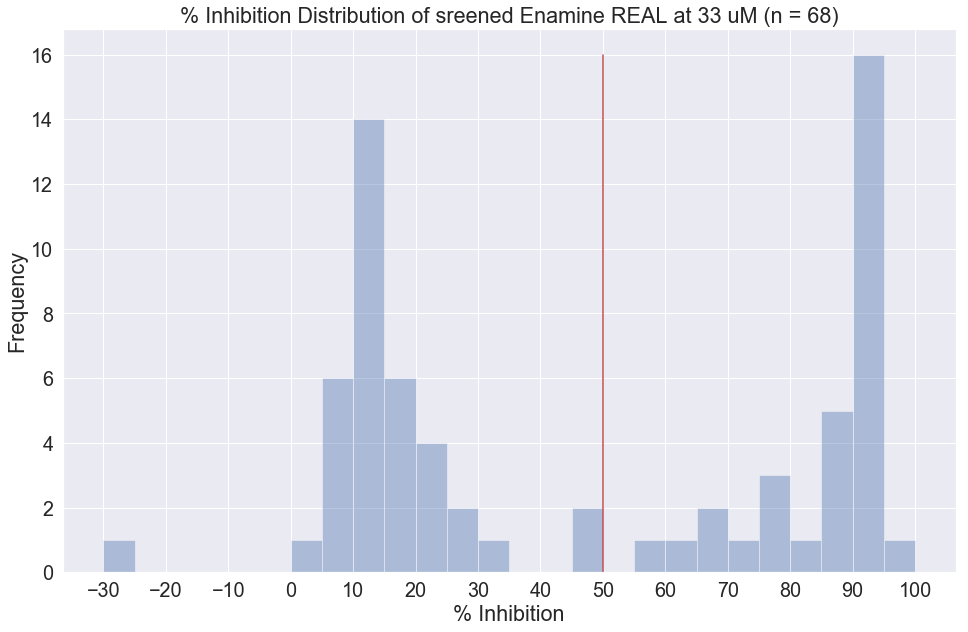

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

bin_range=[i for i in range(-30, 101) if i%5==0]
plt.figure(figsize=figsize)

sns.distplot(res_df[inhib_col], norm_hist=False, kde=False, bins=bin_range)
plt.plot([hit_thresh, hit_thresh], [0, 16], color='r')
plt.title('% Inhibition Distribution of sreened Enamine REAL at 33 uM (n = {})'.format(res_df.shape[0]))
plt.xlabel(inhib_col); plt.xticks([i for i in range(-30, 101) if i%10==0]); plt.ylabel('Frequency')
plt.show()

---
## Total Hits of Ordered Compounds

In [27]:
counts, hits = res_df.shape[0], res_df['Hit'].sum()
summary_df = pd.DataFrame(data=[[counts, hits, counts - hits, 100.0*(hits/counts)]],
                          columns=['Count', 'Hits', 'Misses', 'Hit Rate'], index=['RF-C Enamine REAL'])
summary_df

Count  Hits  Misses   Hit Rate
RF-C Enamine REAL     68    31      37  45.588235

---
## Look at clusters/novel hits

Unique cluster hits counts the number of unique clusters with hits in the prospective dataset.

Novel cluster hits counts the number of unique clusters with hits that were NOT present in the training set. In other words, clusters that the model was not trained on. 

In [4]:
train_hits = train_and_ams_df[train_and_ams_df['Hit'] == 1]

cluster_cols = ['TB_0.4 ID']
cluster_summary = []
for df in [res_df]:
    ref_hits = df[df['Hit'] == 1]
    tmp_list = []
    for cluster_col in cluster_cols:
        cluster_hit_count = ref_hits[cluster_col].unique().shape[0]
        novel_cluster_count = np.setdiff1d(ref_hits[cluster_col].unique(), train_hits[cluster_col].unique()).shape[0]
        tmp_list.extend([cluster_hit_count, novel_cluster_count])
    cluster_summary.append(tmp_list)
cluster_hit_df = pd.DataFrame(data=cluster_summary,
                              columns=['Unique Cluster Hits (TB 0.4)', 'Novel Cluster Hits (TB 0.4)'],
                              index=['RF-C Enamine REAL'])
cluster_hit_df

Unique Cluster Hits (TB 0.4)  Novel Cluster Hits (TB 0.4)
RF-C Enamine REAL                            31                           31

In [5]:
summary_df = pd.concat([summary_df, cluster_hit_df], axis=1)
summary_df

Count  Hits  Misses   Hit Rate  \
RF-C Enamine REAL     68    31      37  45.588235   

                   Unique Cluster Hits (TB 0.4)  Novel Cluster Hits (TB 0.4)  
RF-C Enamine REAL                            31                           31

In [6]:
cols = ['Is Train cluster?', 'Is Train active cluster?', 
        'Is AMS cluster?', 'Is AMS active cluster?']

res_hits = res_df[res_df['Hit'] == 1]
for c in cols:
    print(c, res_hits[c].sum())
    
res_hits[(res_hits['Is Train cluster?'] == 1) | (res_hits['Is AMS cluster?'] == 1)].shape

Is Train cluster? 4
Is Train active cluster? 0
Is AMS cluster? 1
Is AMS active cluster? 0


(5, 33)

---
## Compound Structures

C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)



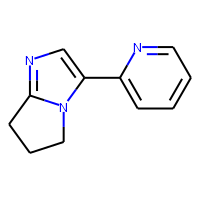
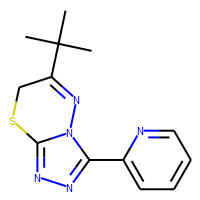
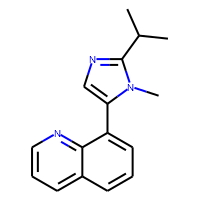
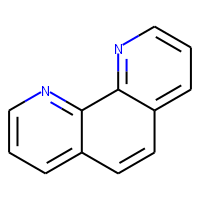
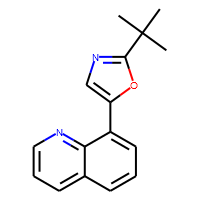
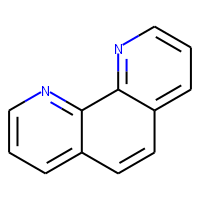
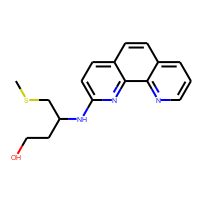
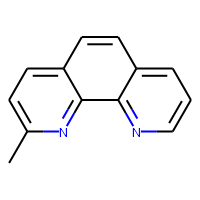
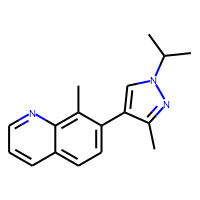
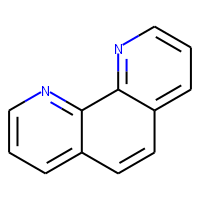
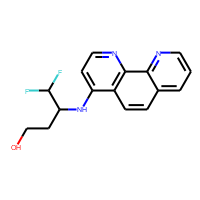
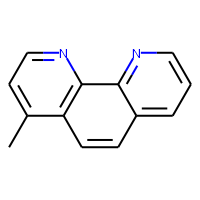
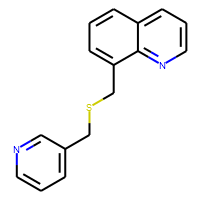
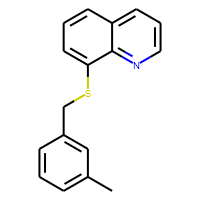
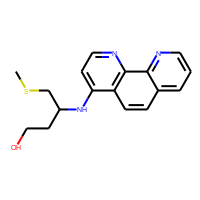
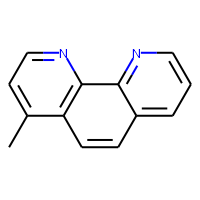
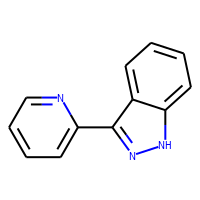
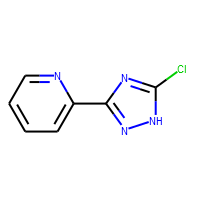
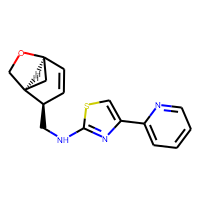
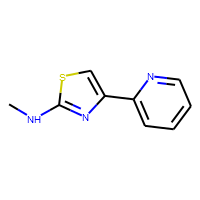
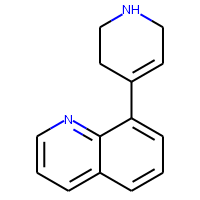
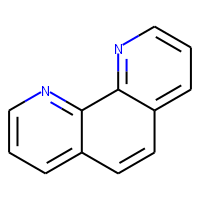
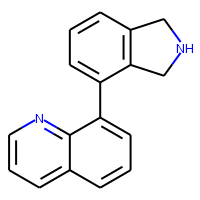
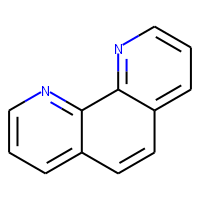
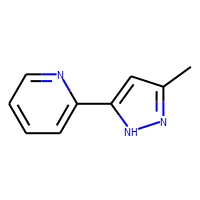
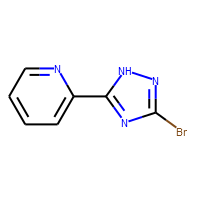
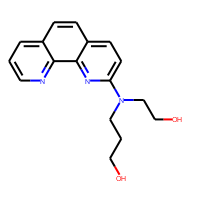
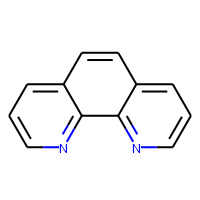
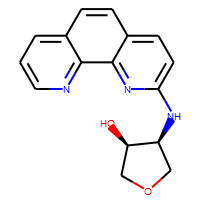
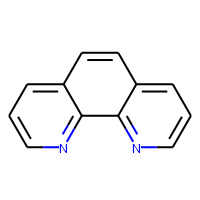
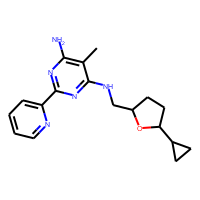
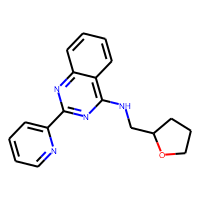
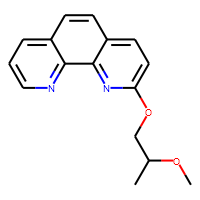
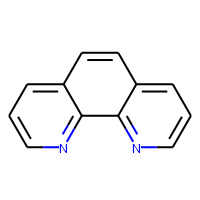
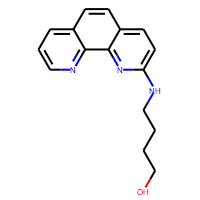
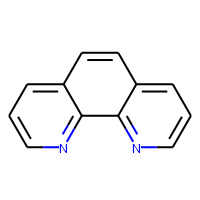
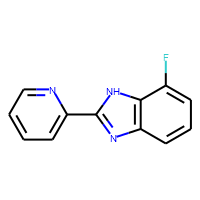
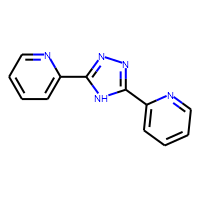
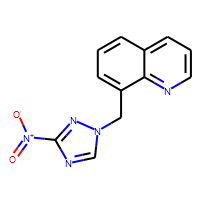
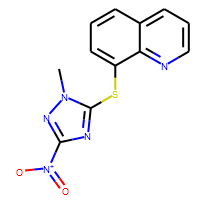
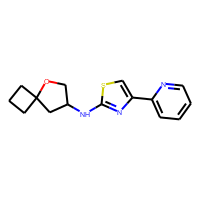
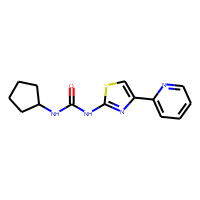
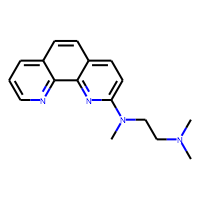
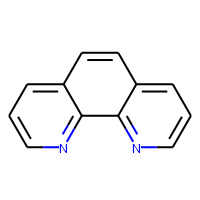
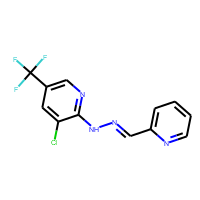
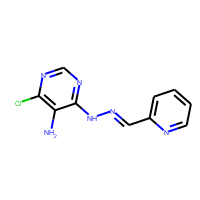
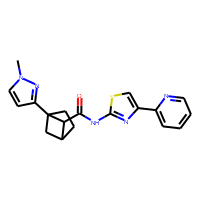
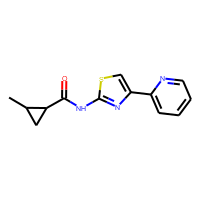
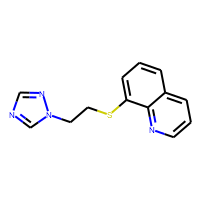
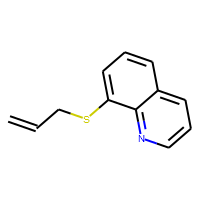
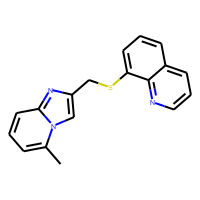
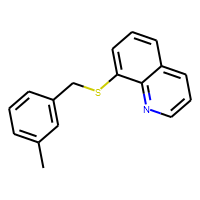
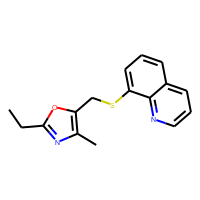
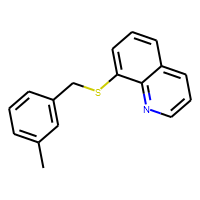
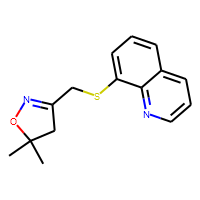
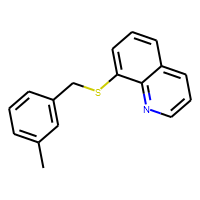
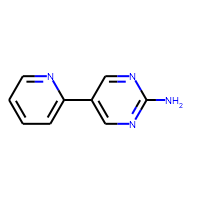
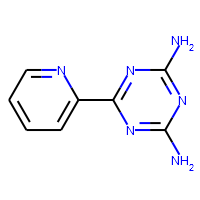
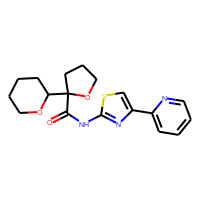
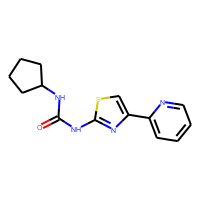
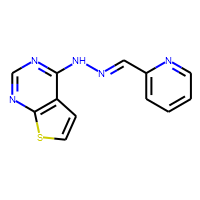
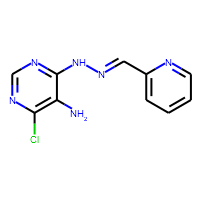
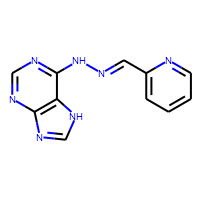
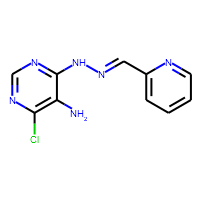
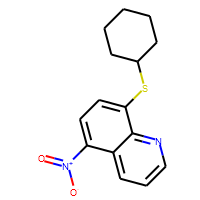
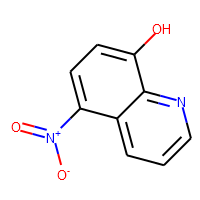
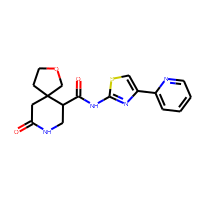
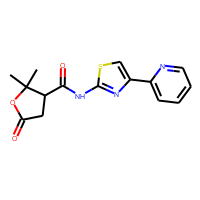
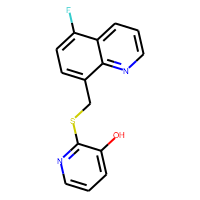
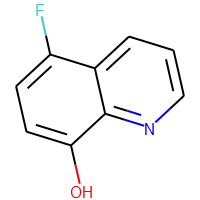
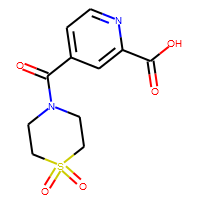
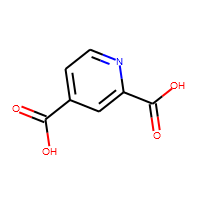
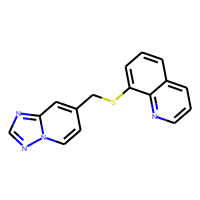
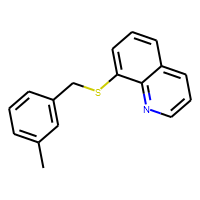
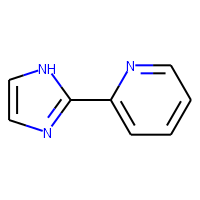
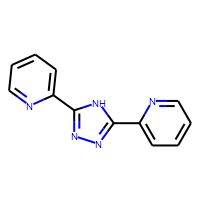
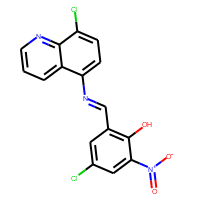
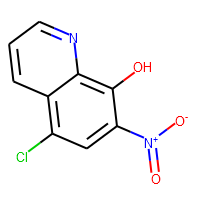
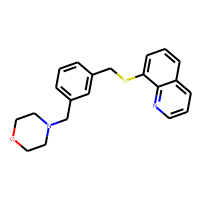
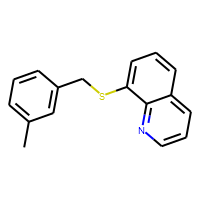
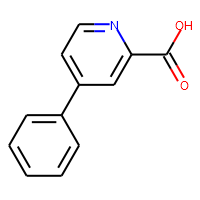
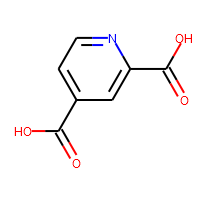
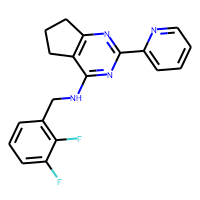
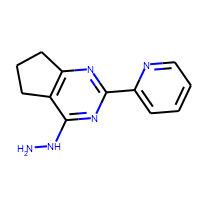
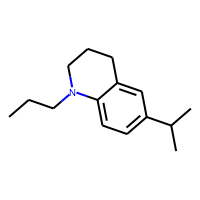
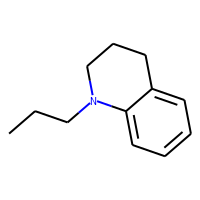
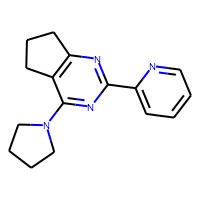
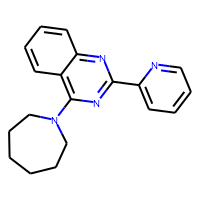
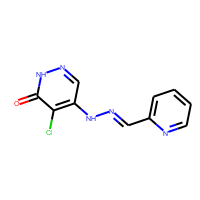
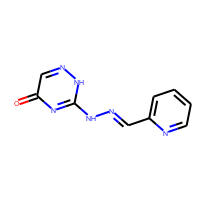
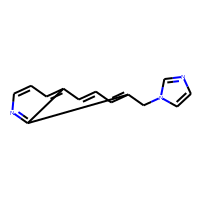
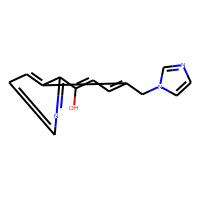
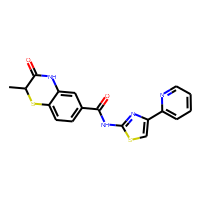
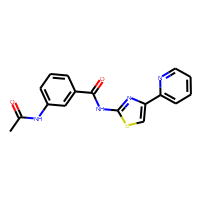
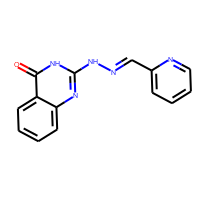
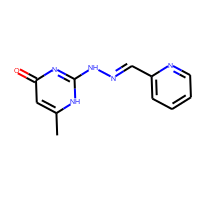
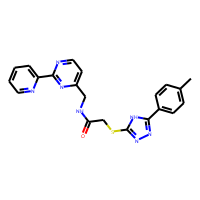
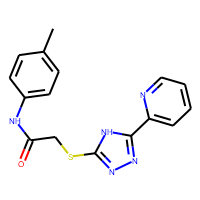
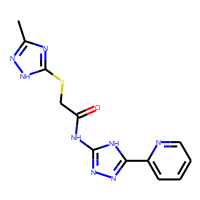
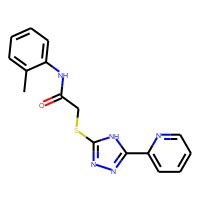
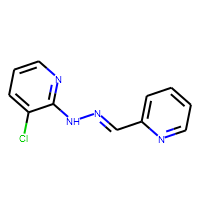
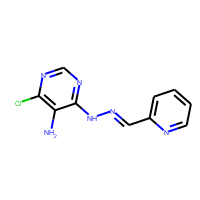
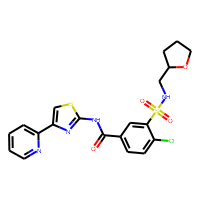
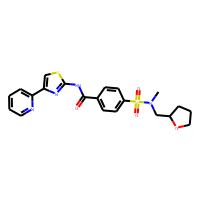
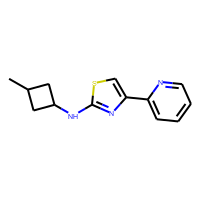
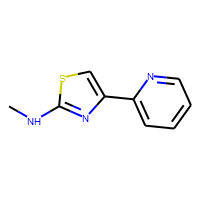
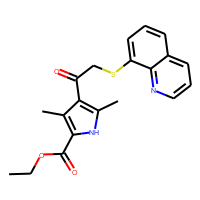
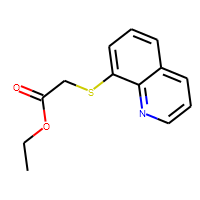
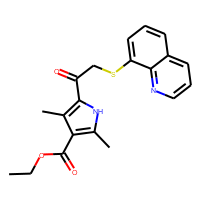
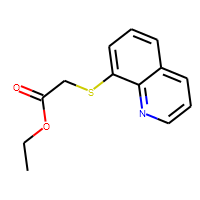
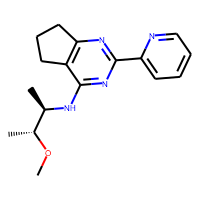
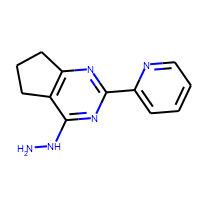
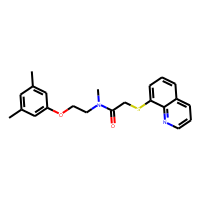
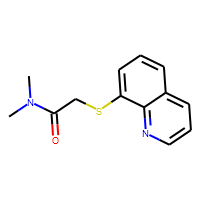
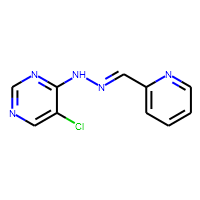
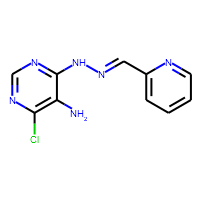
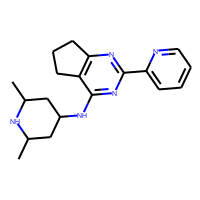
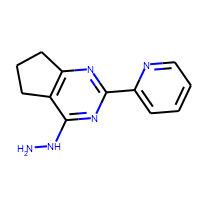
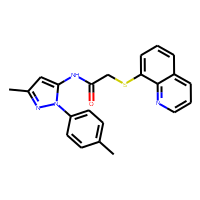
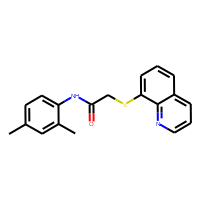
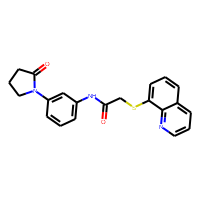
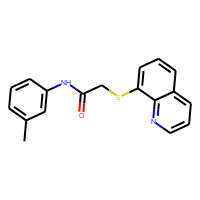
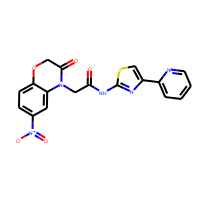
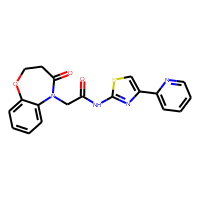
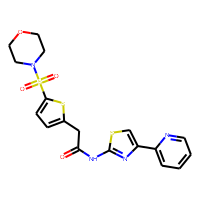
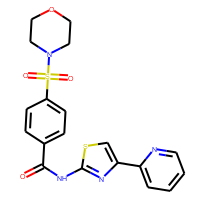
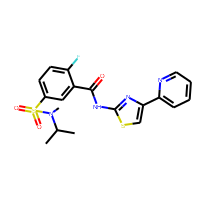
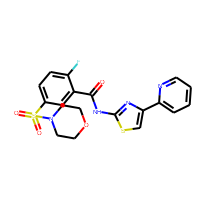
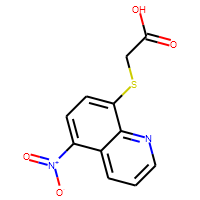
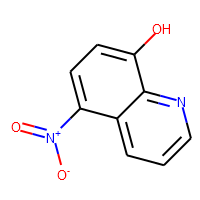
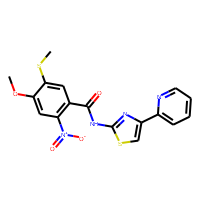
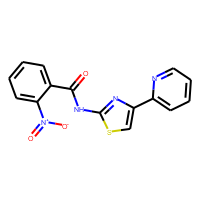
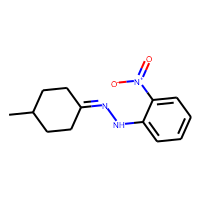
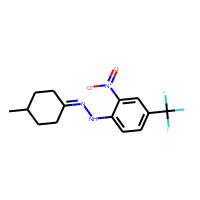
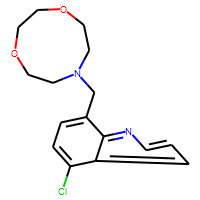
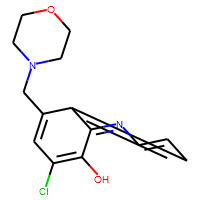

In [13]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from IPython.core.display import HTML
from rdkit.Chem import AllChem
PandasTools.RenderImagesInAllDataFrames(images=True)
DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0
from rdkit.Chem import rdFMCS

def show(df): # see issue: https://github.com/rdkit/rdkit/issues/2673
    return HTML(df.to_html())

def get_sim_df(train_df, prosp_df):
    X_train_actives = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in train_df['1024 MorganFP Radius 2']]).astype(float)
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prosp_df['1024 MorganFP Radius 2']]).astype(float)
    train_prosp_tandist = pairwise_distances(X_prosp, X_train_actives, metric='jaccard')
    sim_info = []
    for i in range(train_prosp_tandist.shape[0]):
        prosp_smiles = prosp_df['rdkit SMILES'].iloc[i]; prosp_mol = Chem.MolFromSmiles(prosp_smiles);
        closest_active_idx = np.argmin(train_prosp_tandist[i,:]); 
        dist = train_prosp_tandist[i,closest_active_idx]
        train_smiles = train_df['rdkit SMILES'].iloc[closest_active_idx]; train_mol = Chem.MolFromSmiles(train_smiles);

        # try to align mols
        try:
            mcs = rdFMCS.FindMCS([train_mol, prosp_mol], ringMatchesRingOnly=True, completeRingsOnly=True)
            template = Chem.MolFromSmarts(mcs.smartsString)
            AllChem.Compute2DCoords(template)
            AllChem.GenerateDepictionMatching2DStructure(train_mol, template)
            AllChem.GenerateDepictionMatching2DStructure(prosp_mol, template)
        except:
            pass
        
        dataset_name = train_df['dataset'].iloc[closest_active_idx]
        if dataset_name == 'train':
            dataset_name = 'Training'
        elif dataset_name == 'ams':
            dataset_name = 'AMS'
        dataset_dist = '{}: {:.2f}'.format(dataset_name, dist)
        sim_info.append((prosp_mol, train_mol, dataset_dist, dist, prosp_df['Hit'].iloc[i]))
        
    sim_df = pd.DataFrame(data=sim_info, 
                          columns=['Prospective Mol', 'Nearest Training or AMS Active', 
                                   'Dataset:Tanimoto Distance',  'Tanimoto Distance', 'Is Hit?'])
    sim_df = sim_df.sort_values('Tanimoto Distance', ascending=False).reset_index(drop=True)
    return sim_df

train_ams_actives = train_and_ams_df[train_and_ams_df['Hit'] == 1]
res_hits_df = res_df[res_df['Hit'] == 1]
sim_df = get_sim_df(train_ams_actives, res_df)
sim_hits_df = get_sim_df(train_ams_actives, res_hits_df)
show(sim_df)

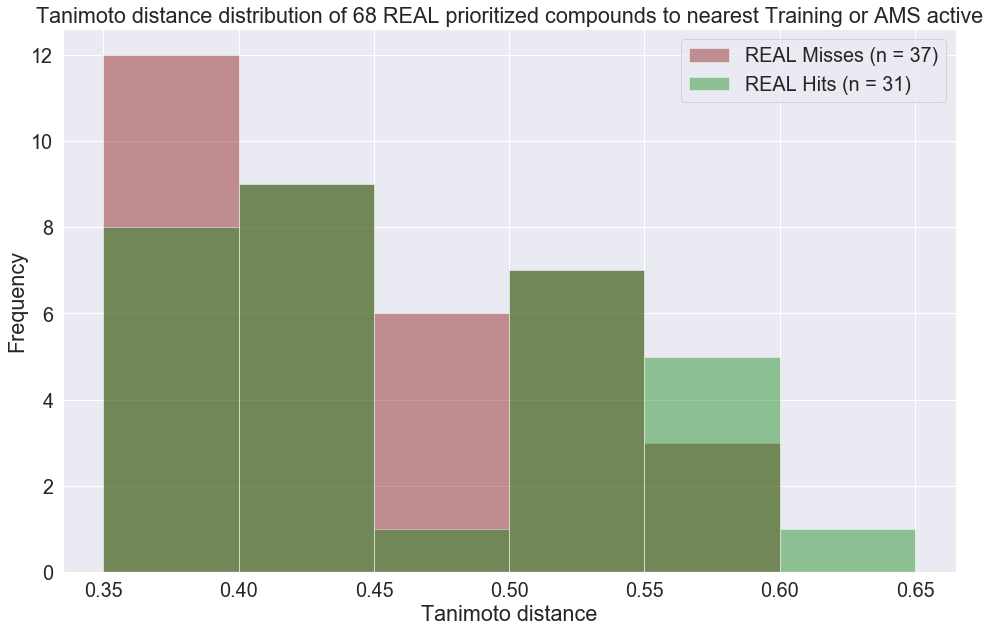

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

tan_dist = sim_df['Tanimoto Distance'].values
bin_range= [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65] #np.linspace(0.35, 0.65, 10)
plt.figure(figsize=figsize)
prosp_hits_dist = sim_df[sim_df['Is Hit?'] == 1]['Tanimoto Distance'].values
prosp_misses_dist = sim_df[sim_df['Is Hit?'] == 0]['Tanimoto Distance'].values

sns.distplot(prosp_misses_dist, bins=bin_range, norm_hist=False, kde=False, color='maroon')  
sns.distplot(prosp_hits_dist, bins=bin_range, norm_hist=False, kde=False, color='green')  
plt.title('Tanimoto distance distribution of 68 REAL prioritized compounds to nearest Training or AMS active')
plt.xlabel('Tanimoto distance'); plt.ylabel('Frequency');
plt.legend(['REAL Misses (n = {})'.format(prosp_misses_dist.shape[0]), 
            'REAL Hits (n = {})'.format(prosp_hits_dist.shape[0])])
plt.show()

---
## Similarity Heatmaps

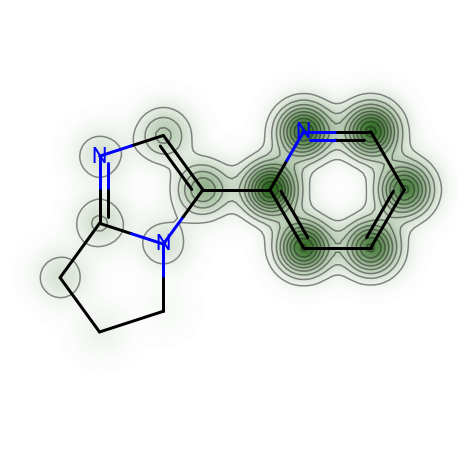

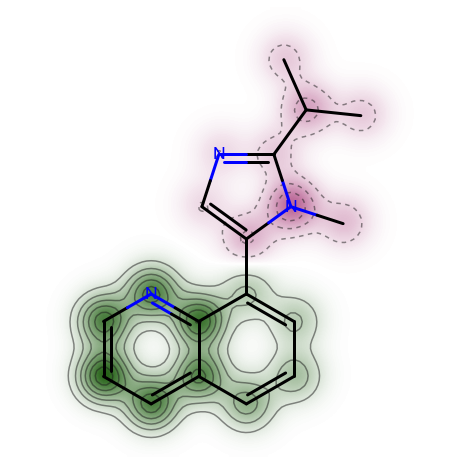

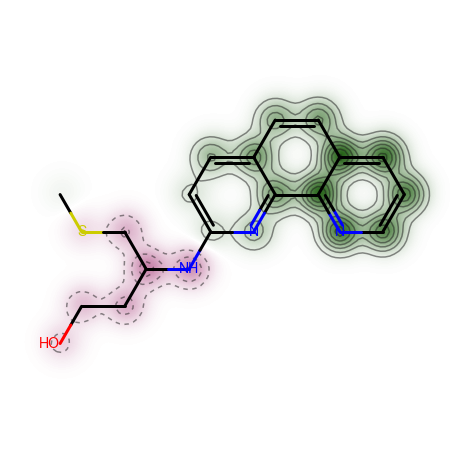

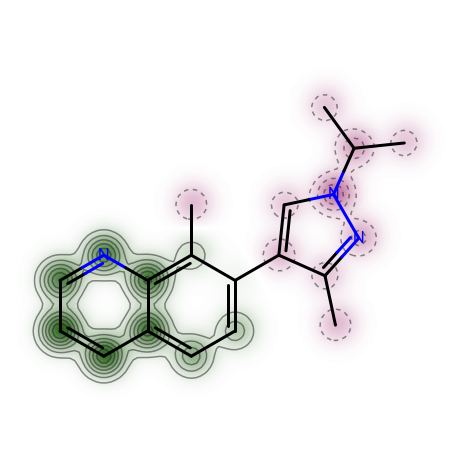

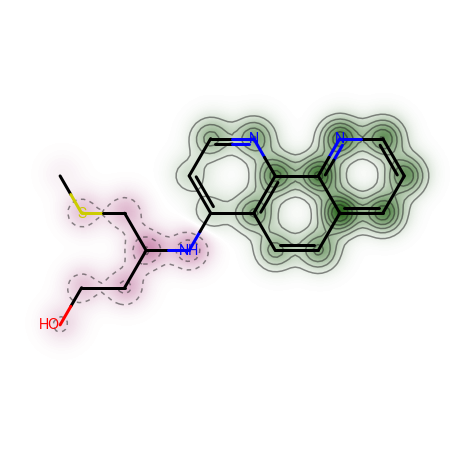

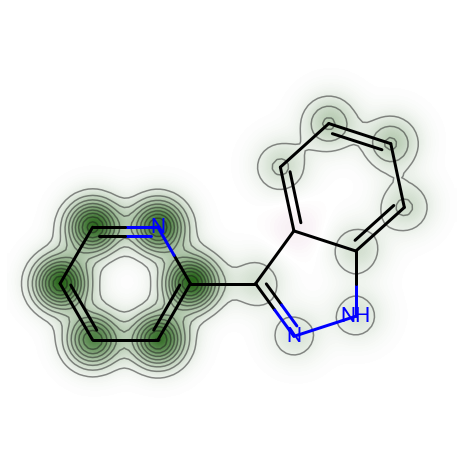

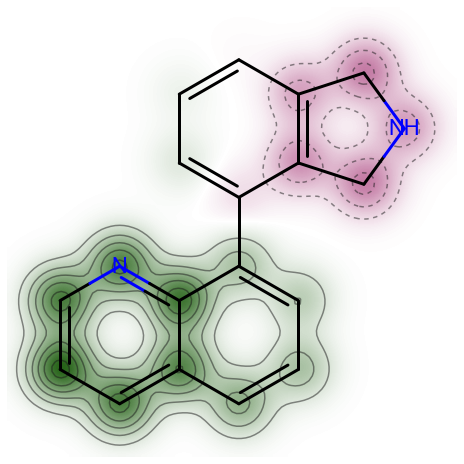

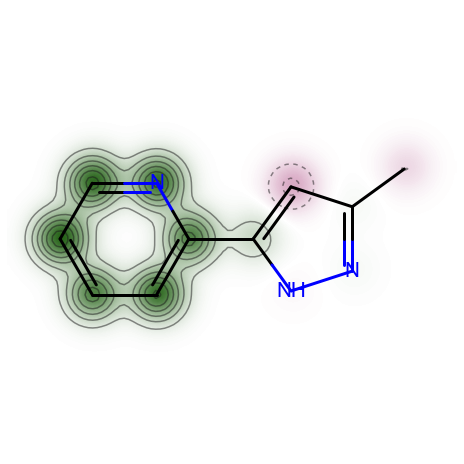

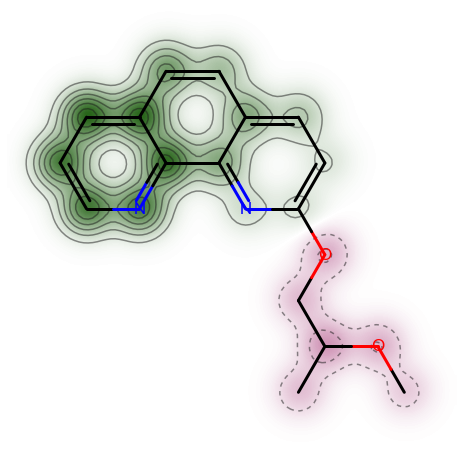

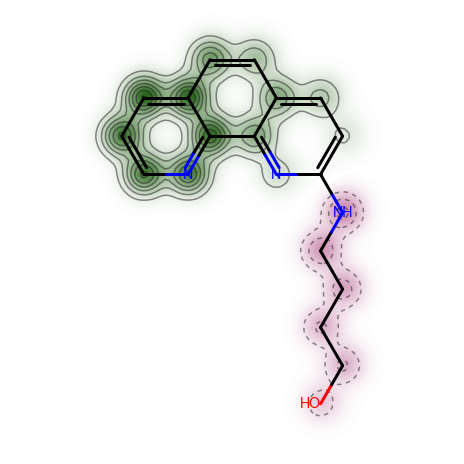

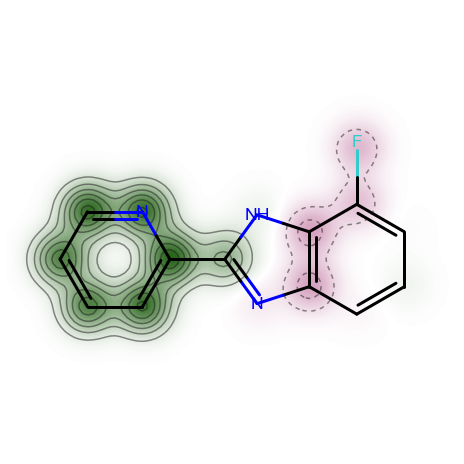

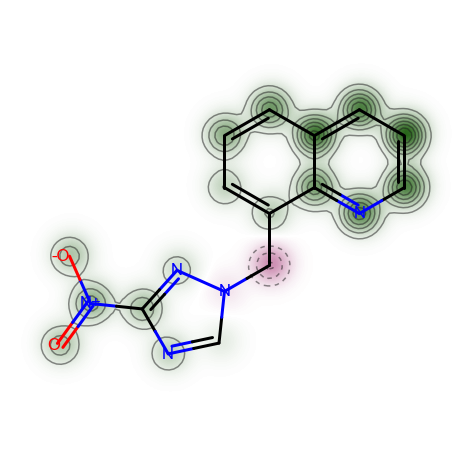

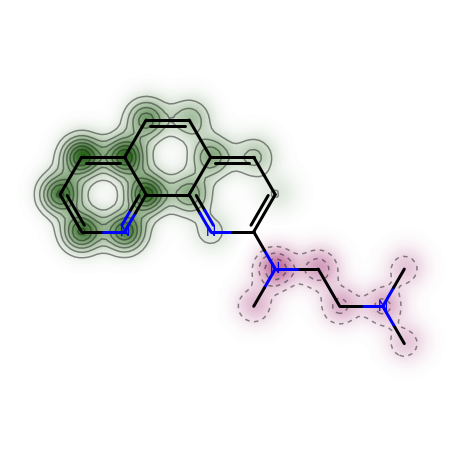

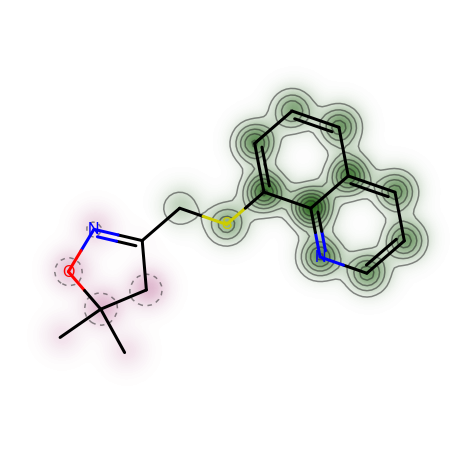

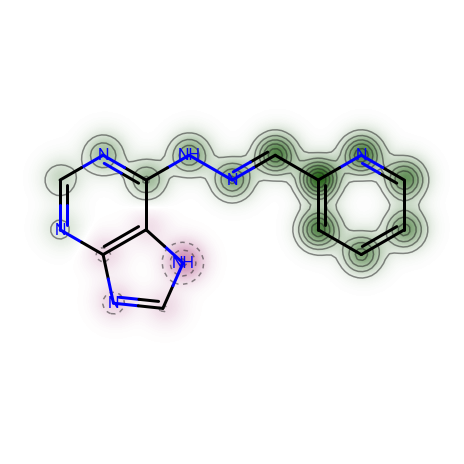

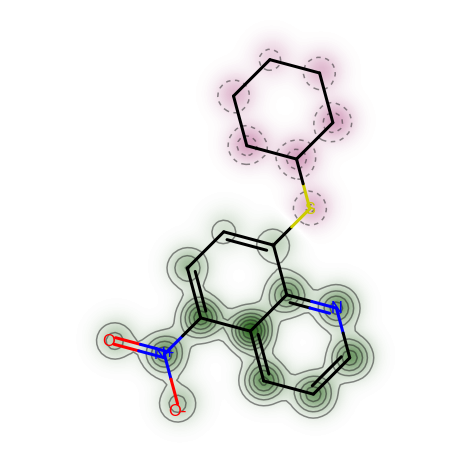

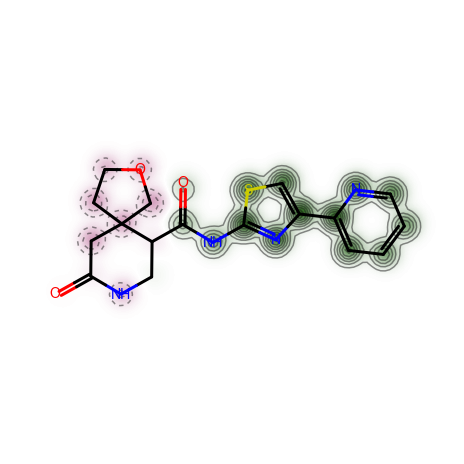

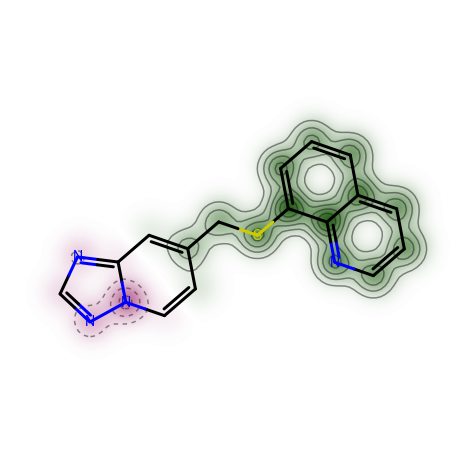

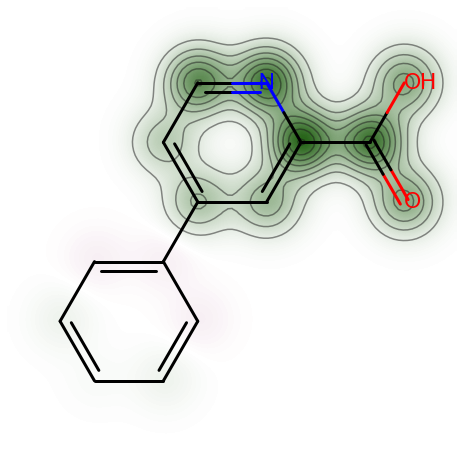

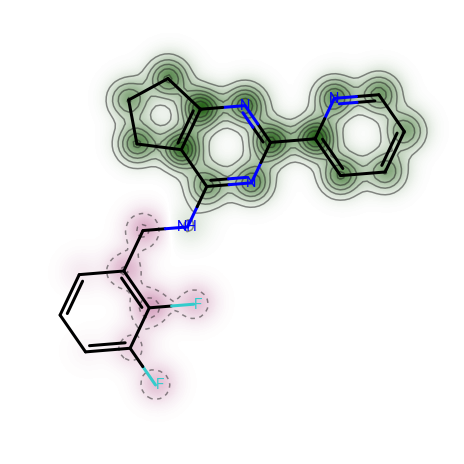

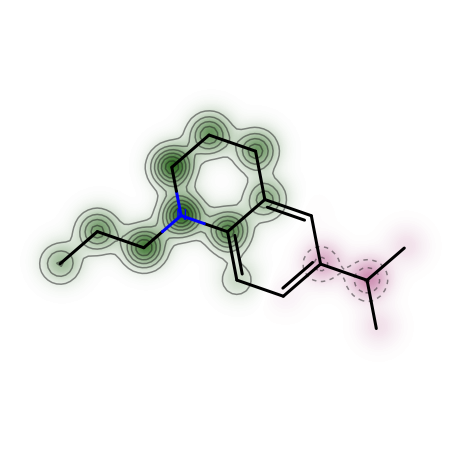

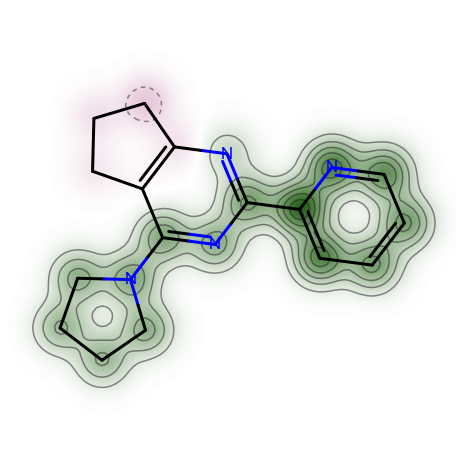

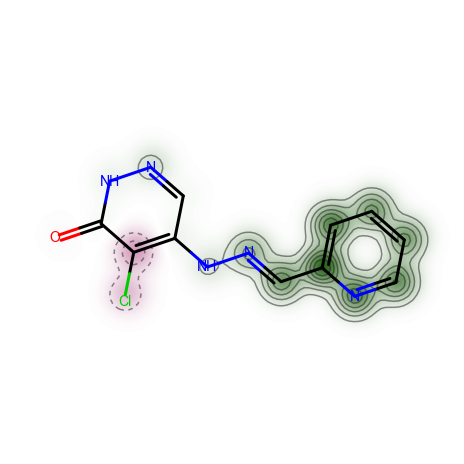

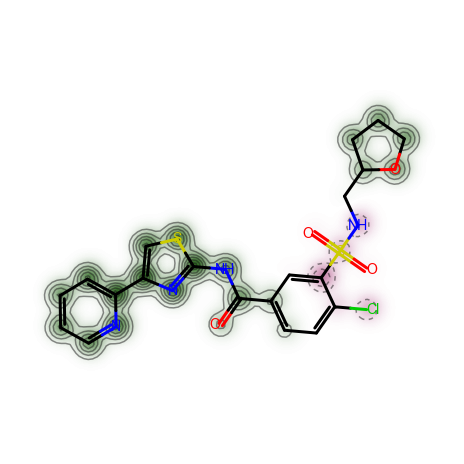

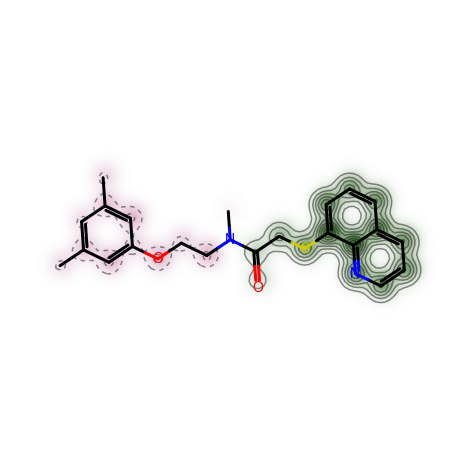

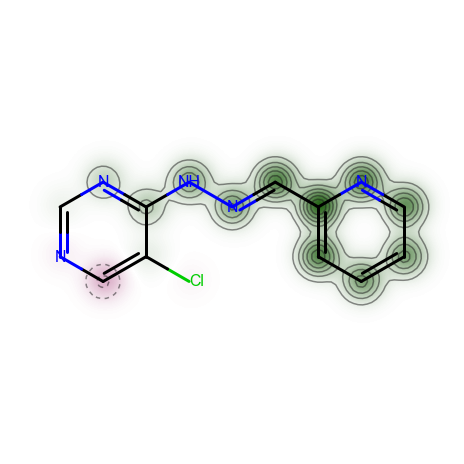

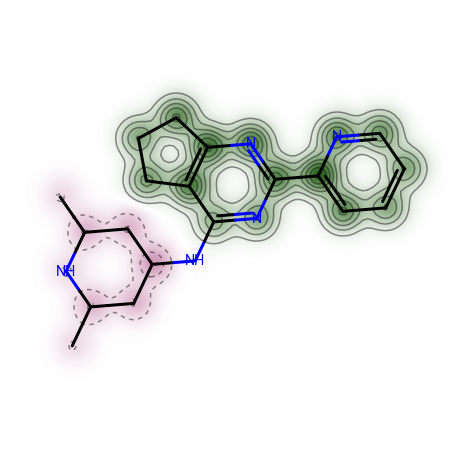

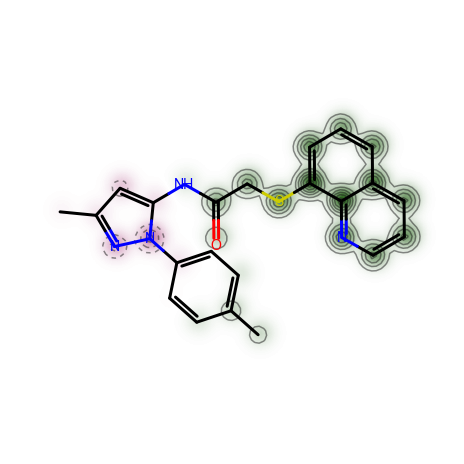

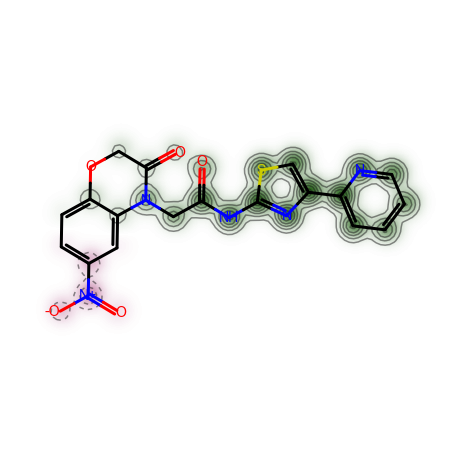

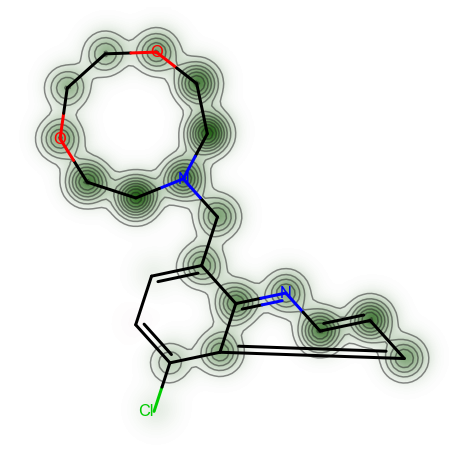

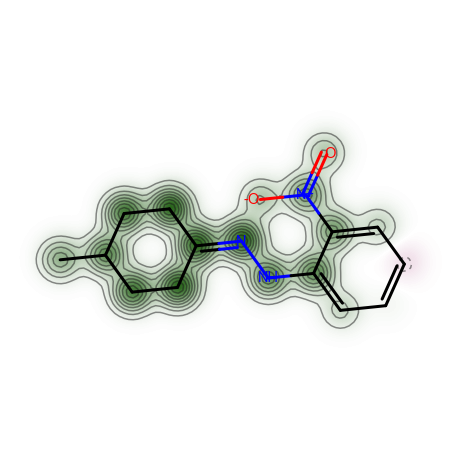

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Draw import SimilarityMaps
FP_radius=2
x = sim_hits_df.copy() #sim_df[sim_df['Is Hit?'] == 1]

for i in range(x.shape[0]):
    Draw.MolToFile(x.iloc[i,0], "./real_results_vis/rf_{}_{}.png".format(i, 'prosp'))
    Draw.MolToFile(x.iloc[i,1], "./real_results_vis/rf_{}_{}.png".format(i, 'train'))
    
    prosp_mol = x.iloc[i,0]
    train_mol = x.iloc[i,1]
    
    sim_func = (lambda a, b: SimilarityMaps.GetMorganFingerprint(a, atomId=b, fpType='bv', radius=FP_radius, nBits=1024))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train_mol, prosp_mol, sim_func)
        
    fig.savefig("./real_results_vis/rf_{}_{}.png".format(i, 'hmap'), bbox_inches='tight')

In [26]:
prefix = '\includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/'
image_fmt = 'rf_{}_{}'
row_fmt = '{} & {} & {} & {} \\\\'
for i, row in sim_hits_df[['Dataset:Tanimoto Distance', 'Tanimoto Distance']].iterrows():
    dataset_tandist = row['Dataset:Tanimoto Distance']
    x1 = prefix + image_fmt.format(i, 'prosp.png}')
    x2 = prefix + image_fmt.format(i, 'train.png}')
    x3 = prefix + image_fmt.format(i, 'hmap.png}')
    row_string = row_fmt.format(x1, x2, x3, dataset_tandist)
    print(row_string)
    print('\\hline')

\includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_prosp.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_train.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_hmap.png} & Training: 0.62 \\
\hline
\includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_prosp.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_train.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_hmap.png} & Training: 0.58 \\
\hline
\includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_2_prosp.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_2_train.png} & \includegraphics[trim=1cm 2cm 1cm 2cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_2_hmap.png} & Training